# Singapore Neighbourhood Locator

IBM Data Science Coursera <br>
Andrew Woon, Nov 2020

## 1. Introduction
When moving to (or visiting) a new country it is key to familiarise yourself with the different neighbourhoods. This report focuses on the neighbourhoods (planning areas) of Singapore with the following two main objectives:

1. Identifying a suitable location to live based on proximity to different venues
2. Familiarising with Singapore to know where to start exploring!


## 2. Data
The primary source of data used for this analysis comes from Foursquare augmented with information of Singapore Regions from wikipedia. 

One limitation of the Foursquare data is that the API limits 100 venues to be returned per search location. However, by default Foursquare will return the most popular venues in the search location, which will be good enough for our research and analysis.

Foursquare APIs used:

1. Venue Categories - https://developer.foursquare.com/docs/api-reference/venues/categories/
2. Explore (nearby venues) - https://developer.foursquare.com/docs/api-reference/venues/explore/

Wikipedia, Singapore Planning Areas - https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore

In [57]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import folium
from geopy.geocoders import Nominatim

Read table from Wikipedia, Singapore Planning Areas and save DataFrame

In [2]:
wiki_link = "https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore"

df_wiki = pd.read_html(wiki_link)[2]
df_wiki.head()

,Name (English),Malay,Chinese,Pinyin,Tamil,Region,Area (km2),Population[7],Density (/km2)
0,Ang Mo Kio,NaN,宏茂桥,Hóng mào qiáo,ஆங் மோ கியோ,North-East,13.94,163950,13400
1,Bedok,*,勿洛,Wù luò,பிடோக்,East,21.69,279380,13000
2,Bishan,NaN,碧山,Bì shān,பீஷான்,Central,7.62,88010,12000
3,Boon Lay,NaN,文礼,Wén lǐ,பூன் லே,West,8.23,30,3.6
4,Bukit Batok,*,武吉巴督,Wǔjí bā dū,புக்கிட் பாத்தோக்,West,11.13,153740,14000


In [3]:
df_wiki = df_wiki.loc[:, ['Name (English)', 'Region']]
df_wiki.columns = ['Neighbourhood', 'Region']

df_wiki.head()

,Neighbourhood,Region
0,Ang Mo Kio,North-East
1,Bedok,East
2,Bishan,Central
3,Boon Lay,West
4,Bukit Batok,West


Get location data (latitude and longitude) of Singapore and neighbourhoods in Singapore using `geopy` library

In [5]:
address = 'Singapore, Singapore'

geolocator = Nominatim(user_agent="sg")
location = geolocator.geocode(address)
sg_lat = location.latitude
sg_long = location.longitude
print('The geographical coordinates of Singapore are {}, {}.'.format(sg_lat, sg_long))

The geographical coordinates of Singapore are 1.3408630000000001, 103.83039182212079.


In [6]:
neighbour_list = []
lat_list = []
long_list = []

for neighbourhood in list(df_wiki['Neighbourhood']):
    location = geolocator.geocode(neighbourhood + ', Singapore')
    neighbour_list.append(neighbourhood)
    lat_list.append(location.latitude)
    long_list.append(location.longitude)
    
sg_dict = {'Neighbourhood': neighbour_list, 'Latitude': lat_list, 'Longitude': long_list}
df_sg = pd.DataFrame.from_dict(sg_dict)
df_sg.head()

,Neighbourhood,Latitude,Longitude
0,Ang Mo Kio,1.370080,103.849523
1,Bedok,1.323976,103.930216
2,Bishan,1.350986,103.848255
3,Boon Lay,1.338550,103.705812
4,Bukit Batok,1.349057,103.749591


Total of 55 neighbourhoods in Singapore

In [7]:
sg_neighbourhoods = df_sg.merge(df_wiki, on='Neighbourhood')
print(sg_neighbourhoods.shape)
sg_neighbourhoods.head()

(55, 4)


,Neighbourhood,Latitude,Longitude,Region
0,Ang Mo Kio,1.370080,103.849523,North-East
1,Bedok,1.323976,103.930216,East
2,Bishan,1.350986,103.848255,Central
3,Boon Lay,1.338550,103.705812,West
4,Bukit Batok,1.349057,103.749591,West


Generate map from `folium` library to view neighbourhoods in Singapore

In [8]:
sg_map = folium.Map(location=[sg_lat, sg_long], zoom_start=10.5)

# add markers to map
for lat, lng, label in zip(sg_neighbourhoods['Latitude'], sg_neighbourhoods['Longitude'], 
                           sg_neighbourhoods['Neighbourhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(sg_map)  
    
sg_map

Parameters to be used for Foursquare API `CLIENT_ID` and `CLIENT_SECRET` are personal and have been sanitised. 

In [60]:
CLIENT_ID = 'client_id' # your Foursquare ID
CLIENT_SECRET = 'client_secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: client_id
CLIENT_SECRET:client_secret


Retrieve all potential venue categories and save JSON result as `categories_json`

In [10]:
import requests

url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
categories_json = requests.get(url).json()["response"]

`parent_category` function gets parent child relationship from venue categories e.g. *Amphitheater* (child) is under the parent category *Arts & Entertainment* and returns a dictionary.

In [11]:
def parent_category(category_list, category_dict, parent_name = ''):
    for data in category_list:      
        if parent_name != '':
            category_dict[data['name']] = parent_name
        if data['categories']:
            parent_category(category_list =data['categories'], category_dict= category_dict, 
                            parent_name = data['name'])
    
    return category_dict

In [12]:
parent_dict = parent_category(categories_json['categories'], {}, '')

Parent child relationship saved in DataFrame `df_child`

In [13]:
df_child = pd.DataFrame.from_dict(parent_dict, orient='index').reset_index()
df_child.columns = ['child', 'parent']
df_child.head(10)

,child,parent
0,Amphitheater,Arts & Entertainment
1,Aquarium,Arts & Entertainment
2,Arcade,Arts & Entertainment
3,Art Gallery,Arts & Entertainment
4,Bowling Alley,Arts & Entertainment
5,Casino,Arts & Entertainment
6,Circus,Arts & Entertainment
7,Comedy Club,Arts & Entertainment
8,Concert Hall,Arts & Entertainment
9,Country Dance Club,Arts & Entertainment


Manually generate full parent child hierarchy for all venue categories by merging DataFrames

In [14]:
df_cat2 = df_child.merge(df_child, how='left', left_on='parent', right_on='child', suffixes=('_0', '_1')) \
                    .drop('child_1', 1)
df_cat2.columns = ['level_2', 'level_1', 'level_0']

df_cat3 = df_cat2.merge(df_cat2, how='left', left_on='level_1', right_on='level_2', 
                        suffixes=('_l', '_r')).drop(['level_2_r', 'level_1_r'],1)
df_cat3.columns = ['level_3','level_2', 'level_1', 'level_0']

df_cat4 = df_cat3.merge(df_cat3, how='left', left_on='level_2', right_on='level_3', 
                        suffixes=('_l', '_r')).drop(['level_3_r','level_2_r', 'level_1_r'],1)
df_cat4.columns = ['level_4','level_3','level_2', 'level_1', 'level_0']

Final category hierarchy stored in `df_categories` DataFrame with `level_0` representing highest venue category and `level_4` representing most low level, detailed venue category. 

If a venue category has less than a 5 tier hierarchy the lowest venue category is kept as `level_4` and the highest level parent category is copied across to `level_0`. For example *Amphitheatre* only has one parent category *Arts & Entertainment*, in the DataFrame `level_4` == *Amphitheatre* and `level_3` == *Arts & Entertainment* would be copied across so `level_2`, `level_1` and `level_0` would also be *Arts & Entertainment*

In [15]:
df_categories = pd.concat([pd.DataFrame.from_dict({'level_4':[data['name'] for data in categories_json['categories']]}),
                df_cat4], 0)

for i in list(range(1,5)):
    df_categories.iloc[:,i] = df_categories.apply(lambda row: row[i-1] if pd.isnull(row[i]) else row[i], axis=1)

Example structure of full 5 tier hierarchy of venue categories

In [16]:
print(df_categories.shape)
df_categories[df_categories['level_1']=='Latin American Restaurant'].head(10)

(970, 5)


,level_4,level_3,level_2,level_1,level_0
380,Acai House,Brazilian Restaurant,South American Restaurant,Latin American Restaurant,Food
381,Baiano Restaurant,Brazilian Restaurant,South American Restaurant,Latin American Restaurant,Food
382,Central Brazilian Restaurant,Brazilian Restaurant,South American Restaurant,Latin American Restaurant,Food
383,Churrascaria,Brazilian Restaurant,South American Restaurant,Latin American Restaurant,Food
384,Empada House,Brazilian Restaurant,South American Restaurant,Latin American Restaurant,Food
385,Goiano Restaurant,Brazilian Restaurant,South American Restaurant,Latin American Restaurant,Food
386,Mineiro Restaurant,Brazilian Restaurant,South American Restaurant,Latin American Restaurant,Food
387,Northeastern Brazilian Restaurant,Brazilian Restaurant,South American Restaurant,Latin American Restaurant,Food
388,Northern Brazilian Restaurant,Brazilian Restaurant,South American Restaurant,Latin American Restaurant,Food
389,Pastelaria,Brazilian Restaurant,South American Restaurant,Latin American Restaurant,Food


`getNearbyVenues` function returns a DataFrame of nearby venues for a list of locations (latitude and longitude)

In [17]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, limit=500, section=''):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&section={}' \
            .format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit,
            section)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [19]:
sg_venues = getNearbyVenues(names=sg_neighbourhoods['Neighbourhood'],
                                   latitudes=sg_neighbourhoods['Latitude'],
                                   longitudes=sg_neighbourhoods['Longitude']
                                  )

Ang Mo Kio
Bedok
Bishan
Boon Lay
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Central Water Catchment
Changi
Changi Bay
Choa Chu Kang
Clementi
Downtown Core
Geylang
Hougang
Jurong East
Jurong West
Kallang
Lim Chu Kang
Mandai
Marina East
Marina South
Marine Parade
Museum
Newton
North-Eastern Islands
Novena
Orchard
Outram
Pasir Ris
Paya Lebar
Pioneer
Punggol
Queenstown
River Valley
Rochor
Seletar
Sembawang
Sengkang
Serangoon
Simpang
Singapore River
Southern Islands
Straits View
Sungei Kadut
Tampines
Tanglin
Tengah
Toa Payoh
Tuas
Western Islands
Western Water Catchment
Woodlands
Yishun


## 3.Methodology and Results

The core methodology, which will be used focuses on unsupervised cluster analysis to identify unseen patterns and similarities across the different neighbourhoods.

From the data collected from Foursquare, we see that a total of 3,322 venue information was captured across the 55 neighbourhoods. The chart below shows the result of plotting the number of venues by neighbourhood, and from this we observe the data limitation mentioned above that a maximum number of 100 venues was collected from a neighbourhood even when the `LIMIT` parameter in the API was toggled to 500. 

Some neighbourhoods can be seen to have far fewer venues mainly from the outskirt and industrial neighbourhoods. The horizontal dotted line shows a cutoff threshold of 20 venues and neighbourhoods below this will not be considered a good area to explore or live in, so will be excluded from further cluster analysis. 

(3322, 7)


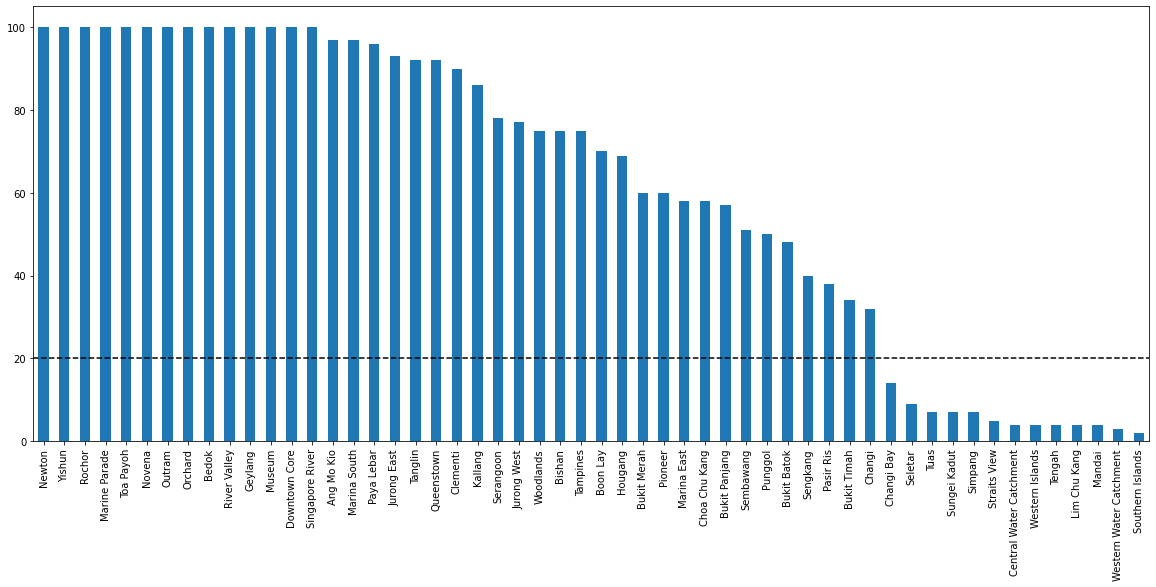

In [20]:
print(sg_venues.shape)

fig, ax = plt.subplots(figsize=(20, 8))
sg_venues['Neighbourhood'].value_counts().plot(kind='bar')
plt.axhline(20, label='cutoff', color='black', linestyle='--')
plt.show()

Remove neighbourhoods with fewer than 20 venues available.

In [21]:
sg_venues_count = sg_venues['Neighbourhood'].value_counts().reset_index()
keep_neighbourhoods = list(sg_venues_count[sg_venues_count['Neighbourhood']>20]['index'])

sg_venues = sg_venues[sg_venues['Neighbourhood'].isin(keep_neighbourhoods)]
sg_venues.shape

(3248, 7)

`venue_encoding` function creates dummy variables according to the specified `level` from the generated venue category hierarchy

In [22]:
def venue_encoding(df, level):
    if level=='level_4':
        df_ve = df.merge(df_categories[['level_4']], left_on='Venue Category', right_on='level_4')
    else:
        df_ve = df.merge(df_categories[['level_4', level]], left_on='Venue Category', right_on='level_4')
    df_onehot = pd.get_dummies(df_ve[[level]], prefix="", prefix_sep="")
    df_onehot['Neighbourhood'] = df_ve['Neighbourhood']
    return df_onehot[[df_onehot.columns[-1]] + list(df_onehot.columns[:-1])]

### 3.1 Venue Category (level 0) Analysis

First analysis will be conducted on the highest venue category level `level_0`, which has 9 different types of venue categories present across the neighbourhoods

In [23]:
df_lvl0 = venue_encoding(sg_venues, 'level_0')
df_lvl0_grp = df_lvl0.groupby('Neighbourhood').mean().reset_index()
df_lvl0_grp.head(10)

,Neighbourhood,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Ang Mo Kio,0.010309,0.010309,0.690722,0.020619,0.092784,0.000000,0.000000,0.144330,0.030928
1,Bedok,0.000000,0.000000,0.800000,0.020000,0.060000,0.000000,0.000000,0.110000,0.010000
2,Bishan,0.040000,0.000000,0.706667,0.000000,0.066667,0.000000,0.000000,0.186667,0.000000
3,Boon Lay,0.028571,0.000000,0.671429,0.014286,0.071429,0.000000,0.014286,0.171429,0.028571
4,Bukit Batok,0.083333,0.000000,0.625000,0.000000,0.125000,0.000000,0.000000,0.125000,0.041667
5,Bukit Merah,0.100000,0.000000,0.416667,0.000000,0.083333,0.000000,0.000000,0.316667,0.083333
6,Bukit Panjang,0.017544,0.000000,0.561404,0.035088,0.087719,0.000000,0.000000,0.228070,0.070175
7,Bukit Timah,0.058824,0.000000,0.029412,0.000000,0.735294,0.029412,0.000000,0.029412,0.117647
8,Changi,0.062500,0.000000,0.312500,0.000000,0.031250,0.000000,0.000000,0.125000,0.468750
9,Choa Chu Kang,0.051724,0.000000,0.551724,0.034483,0.206897,0.000000,0.000000,0.120690,0.034483


`k_clusters` function draws an elbow plot for a specified list of number of clusters to determine the optimal number of clusters for the provided dataset

In [24]:
from sklearn.cluster import KMeans

def k_clusters(df, cluster_range):
    df_clusters = df.drop('Neighbourhood', 1)

    distortions = []
    for k in cluster_range:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df_clusters)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(10,6))
    plt.plot(cluster_range, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

From the plot below we observe the optimal number of clusters for the `level_0` venue categories to be 3, as the gradient with higher numbers of clusters decays after this point.

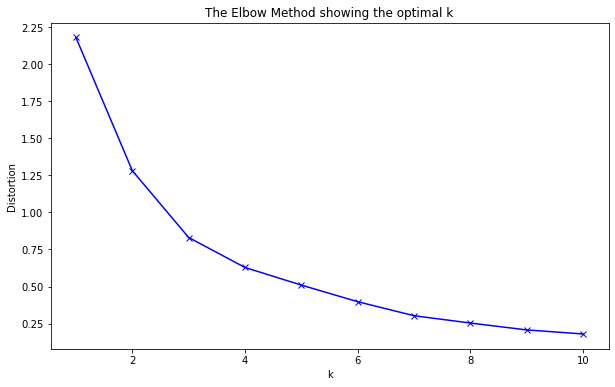

In [25]:
k_clusters(df_lvl0_grp,range(1,11))

`map_clusters` function fits a K Means model for a specified number of clusters and returns a DataFrame of the neighbourhoods with cluster labels and average venue category occurance, and a plotted map of Singapore with cluster markers

In [26]:
import matplotlib.cm as cm
import matplotlib.colors as colors

def map_clusters(df_lvl, kclusters, df_latlon):
    df_clusters = df_lvl.drop('Neighbourhood', 1)
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_clusters)

    df_labels = pd.concat([df_lvl, pd.Series(kmeans.labels_, name='Cluster Labels')], axis=1)
    df_map = df_labels.merge(df_latlon, on='Neighbourhood')

    # create map
    map_clusters = folium.Map(location=[sg_lat, sg_long], zoom_start=11)

    # set color scheme for the clusters
    x = np.arange(kclusters)
    ys = [i + x + (i*x)**2 for i in range(kclusters)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    # add markers to the map
    markers_colors = []
    for lat, lon, poi, cluster in zip(df_map['Latitude'], df_map['Longitude'], 
                                      df_map['Neighbourhood'], df_map['Cluster Labels']):
        label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=5,
            popup=label,
            color=rainbow[cluster-1],
            fill=True,
            fill_color=rainbow[cluster-1],
            fill_opacity=0.7).add_to(map_clusters)

    return df_map, map_clusters

The map below shows the three plotted clusters with:

* Cluster 0 in Red
* Cluster 1 in Green (cyan)
* Cluster 2 in Purple

We observe there are only two neighbourhoods in cluster 1, 12 in cluster 2 and 24 in cluster 0. From the map it suggests cluster 1 neighbourhoods are business/industrial areas with the largest group of these neighbourhoods close to the central business district, while cluster 0 are more traditional residential neighbourhoods.

In [27]:
df_lvl0_map, lvl0_map = map_clusters(df_lvl0_grp, 3, sg_neighbourhoods)

lvl0_map

The charts below show the mean venue categories by cluster to provide a better understanding of the differences between the clusters. Cluster 1 is significantly different from the other two with the main venue category being `Outdoors and Recreation`. As there are only two neighbourhoods in this cluster, drilling down we see that *Marina East* contains Gardens by the Bay and *Bukit Timah* contains a large nature reserve. 

The neighbourhoods in cluster 0 thought of as residential areas predominantly contain `Food` venues, which is logical as there is likely no significant landmarks in these areas and the Food venues cater for the residents of the neighbourhood. Cluster 1 thought to be more business/industrial focused neighbourhoods still have `Food` venues as the predominant category representing 50%, but also contain twice as may Nightlife, Shop & Services and Travel & Transport venues when compared to cluster 0. 

With this preliminary analysis, we would lean towards neighbourhoods in cluster 0 to live in, while the neighbourhoods in cluster 2 and 1 would be interesting to explore for outdoor activities and nightlife/shopping respectively. As `Food` venues outweigh the other categories significantly, the next step in the analysis will be to determine food diversity across the neighbourhoods to once again find a suitable neighbourhood to reside in and others to explore.

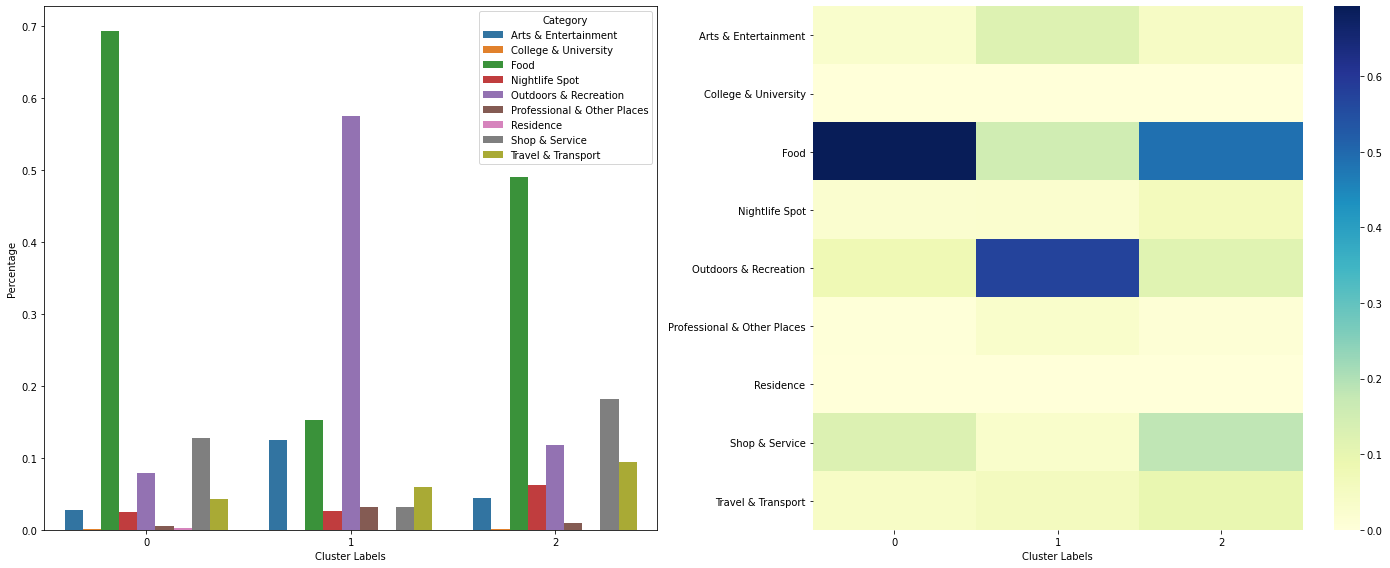

In [28]:
df_lvl0_bar = pd.melt(df_lvl0_map.groupby('Cluster Labels').mean().reset_index(), id_vars=['Cluster Labels'],
        value_vars=list(df_lvl0_map.columns[1:10]), var_name='Category', value_name='Percentage')

fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
sns.barplot(data=df_lvl0_bar, x='Cluster Labels', y='Percentage', hue='Category', ax=ax[0])
sns.heatmap(df_lvl0_map.groupby('Cluster Labels').mean().iloc[:,0:9].transpose(), cmap="YlGnBu", ax=ax[1])

plt.tight_layout()
plt.show()

In [29]:
sg_neighbourhoods.head()

,Neighbourhood,Latitude,Longitude,Region
0,Ang Mo Kio,1.370080,103.849523,North-East
1,Bedok,1.323976,103.930216,East
2,Bishan,1.350986,103.848255,Central
3,Boon Lay,1.338550,103.705812,West
4,Bukit Batok,1.349057,103.749591,West


### 3.2 Food Category Analysis

From Foursquare retrieve only `Food` venues for analysis

In [30]:
sg_food = getNearbyVenues(names=sg_neighbourhoods['Neighbourhood'],
                                   latitudes=sg_neighbourhoods['Latitude'],
                                   longitudes=sg_neighbourhoods['Longitude'],
                                   section='food'
                                  )

Ang Mo Kio
Bedok
Bishan
Boon Lay
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Central Water Catchment
Changi
Changi Bay
Choa Chu Kang
Clementi
Downtown Core
Geylang
Hougang
Jurong East
Jurong West
Kallang
Lim Chu Kang
Mandai
Marina East
Marina South
Marine Parade
Museum
Newton
North-Eastern Islands
Novena
Orchard
Outram
Pasir Ris
Paya Lebar
Pioneer
Punggol
Queenstown
River Valley
Rochor
Seletar
Sembawang
Sengkang
Serangoon
Simpang
Singapore River
Southern Islands
Straits View
Sungei Kadut
Tampines
Tanglin
Tengah
Toa Payoh
Tuas
Western Islands
Western Water Catchment
Woodlands
Yishun


Group `Food` venues by `level_3` in category hierarchy, which groups restaurants/eateries generally by cuisine as shown in the DataFrame below.

In [31]:
sg_food = sg_food[sg_food['Neighbourhood'].isin(keep_neighbourhoods)]

df_food3 = venue_encoding(sg_food, 'level_3')
df_food3_grp = df_food3.groupby('Neighbourhood').mean().reset_index()
df_food3_grp.head(10)

,Neighbourhood,Asian Restaurant,Caribbean Restaurant,Chinese Restaurant,Food,Hawaiian Restaurant,Indian Restaurant,Japanese Restaurant,Mexican Restaurant,Middle Eastern Restaurant,South American Restaurant,Spanish Restaurant
0,Ang Mo Kio,0.204082,0.0,0.020408,0.734694,0.0,0.0,0.040816,0.000000,0.0,0.0,0.000000
1,Bedok,0.307692,0.0,0.010989,0.637363,0.0,0.0,0.032967,0.010989,0.0,0.0,0.000000
2,Bishan,0.250000,0.0,0.025000,0.700000,0.0,0.0,0.025000,0.000000,0.0,0.0,0.000000
3,Boon Lay,0.225806,0.0,0.016129,0.709677,0.0,0.0,0.032258,0.016129,0.0,0.0,0.000000
4,Bukit Batok,0.267857,0.0,0.000000,0.732143,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
5,Bukit Merah,0.265306,0.0,0.000000,0.714286,0.0,0.0,0.000000,0.000000,0.0,0.0,0.020408
6,Bukit Panjang,0.169811,0.0,0.018868,0.735849,0.0,0.0,0.075472,0.000000,0.0,0.0,0.000000
7,Bukit Timah,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
8,Changi,0.100000,0.0,0.050000,0.825000,0.0,0.0,0.025000,0.000000,0.0,0.0,0.000000
9,Choa Chu Kang,0.192308,0.0,0.000000,0.769231,0.0,0.0,0.038462,0.000000,0.0,0.0,0.000000


Performing the elbow analysis similar to before, we also observe the optimal number of clusters for K means is 3.

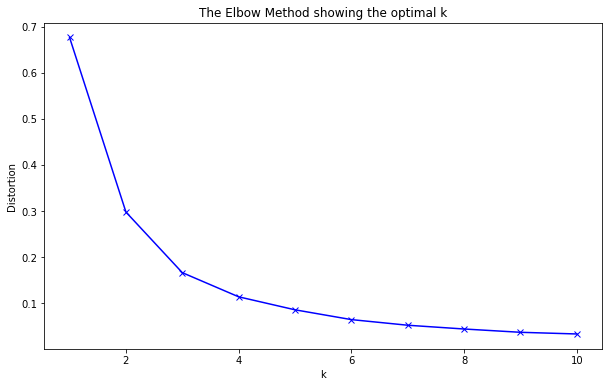

In [32]:
k_clusters(df_food3_grp,range(1,11))

Generating the map of the clusters, we observe differences when compared against the clusters generated previously by venue category. There are 3 clusters again, but are more balanced with 15 in cluster 0, 16 in cluster 1 and 7 in cluster 2. There does not seem to be any distinct pattern for neighbourhood location and diversity of cuisine here.

In [33]:
df_food3_map, food3_map = map_clusters(df_food3_grp, 3, sg_neighbourhoods)

food3_map

Performing an analysis grouped by cuisine, we observe that restaurants/eateries under `Food` category and not confined to any cuisine dominates the breakdown, the second closest cuisine is `Asian`.

The takeaways from these charts are limited, but they suggest neighbourhoods in cluster 1 are not attributed to any type of cuisine with over 80% of restaurants under Food, one possible reason is due to a high number of international restaurants or cafes and bakeries not associated to any cuisine, while clusters 0 and 2 are similar in breakdown with more Asian Restaurants. 

A lower level analysis will be undertaken using the lowest venue category `level_4` to see if any particular trends or patterns can be found.

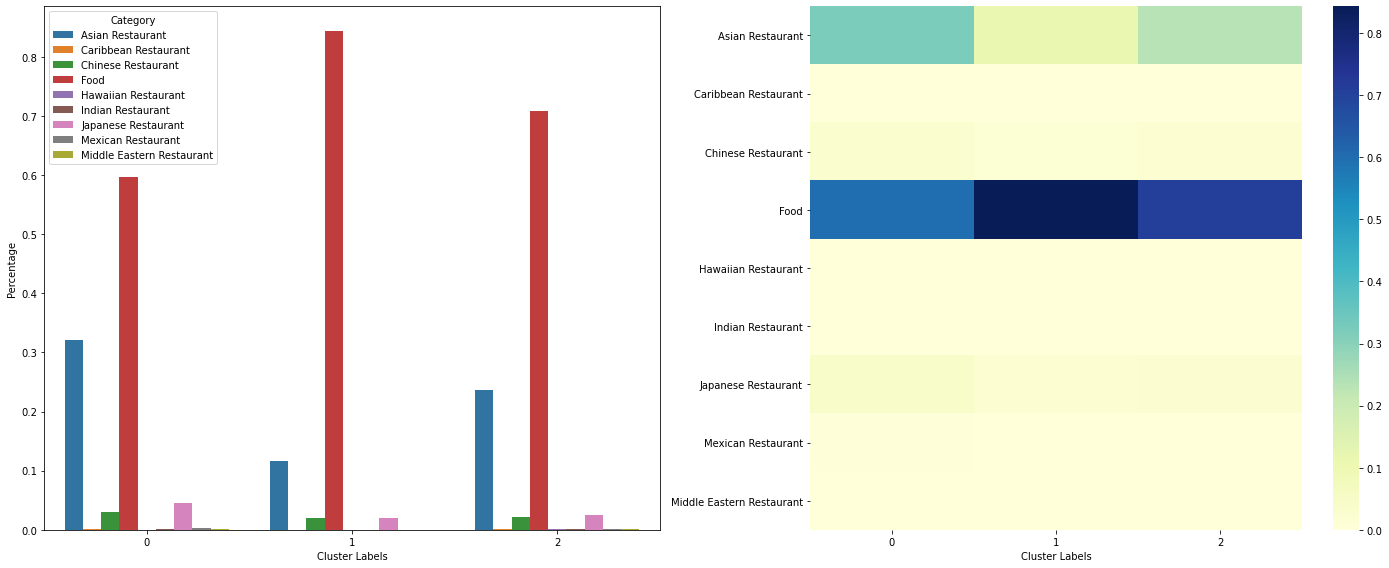

In [34]:
df_food3_bar = pd.melt(df_food3_map.groupby('Cluster Labels').mean().reset_index(), id_vars=['Cluster Labels'],
        value_vars=list(df_food3_map.columns[1:10]), var_name='Category', value_name='Percentage')

fig, ax = plt.subplots(figsize=(20, 8), ncols=2)
sns.barplot(data=df_food3_bar, x='Cluster Labels', y='Percentage', hue='Category', ax=ax[0])
sns.heatmap(df_food3_map.groupby('Cluster Labels').mean().iloc[:,0:9].transpose(), cmap="YlGnBu", ax=ax[1])

plt.tight_layout()
plt.show()

Generate DataFrame using venue category `level_4`, snapshot below shows 100 different categories of Food venues across the neighbourhoods.

In [35]:
df_food4 = venue_encoding(sg_food, 'level_4')
df_food4_grp = df_food4.groupby('Neighbourhood').mean().reset_index()
df_food4_grp.head(10)

,Neighbourhood,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,Belgian Restaurant,Bistro,...,Swiss Restaurant,Szechuan Restaurant,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Theme Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Ang Mo Kio,0.010204,0.0,0.030612,0.000000,0.030612,0.0,0.020408,0.0,0.010204,...,0.0,0.0,0.0,0.000000,0.020408,0.0,0.0,0.051020,0.0,0.000000
1,Bedok,0.010989,0.0,0.087912,0.000000,0.000000,0.0,0.065934,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.032967,0.0,0.0,0.021978,0.0,0.010989
2,Bishan,0.000000,0.0,0.062500,0.000000,0.037500,0.0,0.050000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.050000,0.0,0.0,0.012500,0.0,0.000000
3,Boon Lay,0.000000,0.0,0.161290,0.000000,0.016129,0.0,0.016129,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.016129
4,Bukit Batok,0.035714,0.0,0.035714,0.000000,0.017857,0.0,0.017857,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.017857,0.0,0.0,0.017857,0.0,0.000000
5,Bukit Merah,0.020408,0.0,0.081633,0.000000,0.020408,0.0,0.081633,0.0,0.000000,...,0.0,0.0,0.0,0.020408,0.000000,0.0,0.0,0.000000,0.0,0.000000
6,Bukit Panjang,0.000000,0.0,0.113208,0.000000,0.018868,0.0,0.075472,0.0,0.018868,...,0.0,0.0,0.0,0.000000,0.018868,0.0,0.0,0.000000,0.0,0.000000
7,Bukit Timah,0.000000,0.0,0.000000,0.333333,0.000000,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.333333,0.0,0.000000
8,Changi,0.000000,0.0,0.025000,0.000000,0.050000,0.0,0.075000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.025000
9,Choa Chu Kang,0.000000,0.0,0.057692,0.000000,0.019231,0.0,0.057692,0.0,0.019231,...,0.0,0.0,0.0,0.000000,0.019231,0.0,0.0,0.000000,0.0,0.019231


Clustering the neighbourhoods on venue category `level_4`, again we observe the optimal number of clusters = 3.

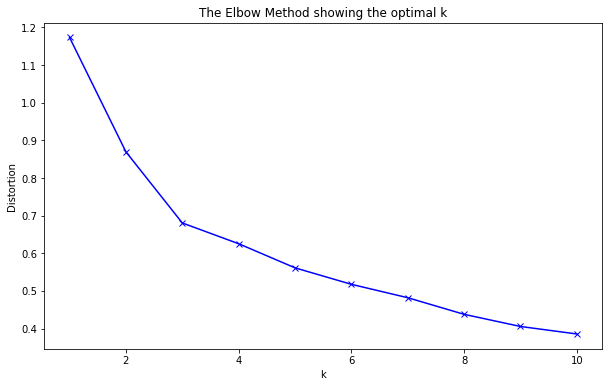

In [36]:
k_clusters(df_food4_grp,range(1,11))

Generating the map of the different clusters, we observe a similar distribution with the first map with cluster 0 (red) focused on business/industrial neighbourhoods centered around the central business district, cluster 1 (purple) the outskirt residential neighbourhoods and cluster 2 only containing *Bukit Timah* a more outdoor recreational area. 

In [37]:
df_food4_map, food4_map = map_clusters(df_food4_grp, 3, sg_neighbourhoods)

food4_map

`return_most_common_venues` function returns the names of the most common venues after specifying the top x number.

In [38]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Generate DataFrame of most common restaurants by cluster

In [39]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Cluster Labels']
for ind in np.arange(num_top_venues):
    try:
        columns.append(ind+1)
#         columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append(ind+1)
#         columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
food_venues_sorted = pd.DataFrame(columns=columns)
df_food4_grp = df_food4_map.iloc[:,:-3].groupby(['Cluster Labels']).mean().reset_index()
food_venues_sorted['Cluster Labels'] = df_food4_grp['Cluster Labels']

for ind in np.arange(df_food4_grp.shape[0]):
    food_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_food4_grp.iloc[ind, :], num_top_venues)
    
food_venues_sorted

,Cluster Labels,1,2,3,4,5,6,7,8,9,10
0,0,Café,Japanese Restaurant,Chinese Restaurant,Bakery,Indian Restaurant,Italian Restaurant,Food Court,Seafood Restaurant,Asian Restaurant,Restaurant
1,1,Chinese Restaurant,Food Court,Asian Restaurant,Café,Fast Food Restaurant,Bakery,Japanese Restaurant,Noodle House,Indian Restaurant,Seafood Restaurant
2,2,Vegetarian / Vegan Restaurant,Australian Restaurant,Café,Wings Joint,Food Court,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,English Restaurant,Falafel Restaurant


Generate DataFrame mapping the above venue categories to the parent category from `level_3`.

In [40]:
lvl3_dict = {}

for i in range(1,11):
    lvl3_dict[i] = list(food_venues_sorted[['Cluster Labels', i]].merge(df_categories[['level_4', 'level_3']], 
                                              left_on=i, right_on='level_4').sort_values('Cluster Labels')['level_3'])
    food_venues_level3 = pd.DataFrame.from_dict(lvl3_dict)

In [41]:
food_venues_level3

,1,2,3,4,5,6,7,8,9,10
0,Food,Asian Restaurant,Asian Restaurant,Food,Food,Food,Food,Food,Food,Food
1,Asian Restaurant,Food,Food,Food,Food,Food,Asian Restaurant,Asian Restaurant,Food,Food
2,Food,Food,Food,Food,Food,Food,Food,Food,Food,Food


From the heatmap below, we see cluster 2 (only containing neighbourhood *Bukit Timah*) has more international cuisine foods and no Asian restaurants, while clusters 0 and 1 have similar restaurants in their top 10 with minor position variations e.g. Cafes are more common in the business/industrial area while Chinese restaurants are favoured in the residential areas.

In terms of diversity of cuisine both clusters 0 and 1 are similar.

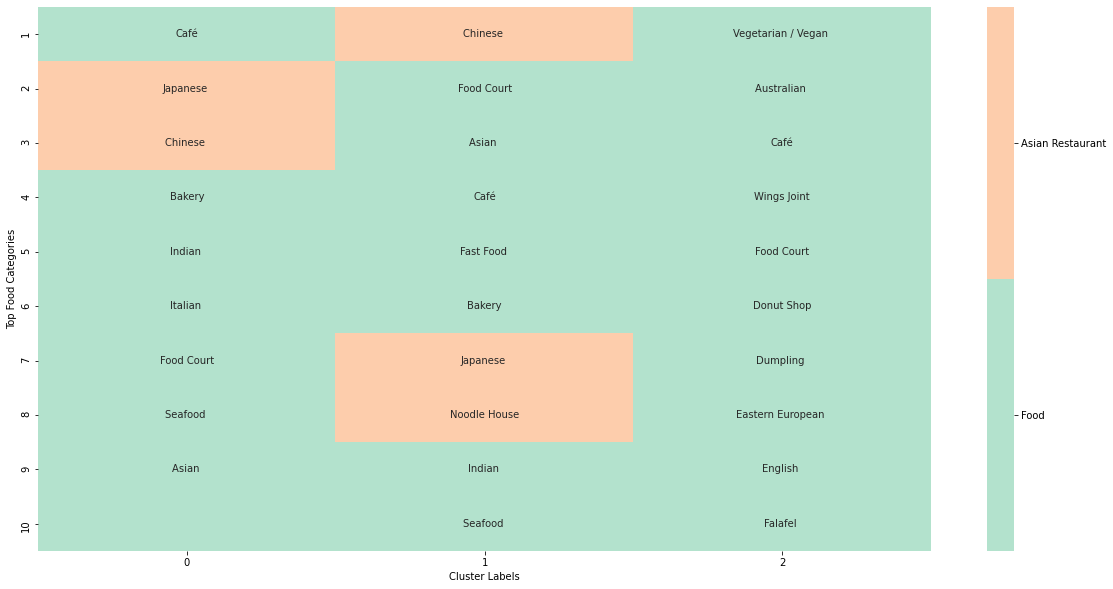

In [42]:
value_to_int = {j:i for i,j in enumerate(pd.unique(food_venues_level3.values.ravel()))}
n = len(value_to_int)     
# discrete colormap (n samples from a given cmap)
cmap = sns.color_palette("Pastel2", n) 

fig, ax = plt.subplots(figsize=(20,10))

labels = np.array(food_venues_sorted.iloc[:,1:].transpose().apply(lambda x: x.str.replace('Restaurant', '')))
ax = sns.heatmap(food_venues_level3.replace(value_to_int).transpose(), cmap=cmap, annot=labels, fmt = '') 
# modify colorbar:
colorbar = ax.collections[0].colorbar 
r = colorbar.vmax - colorbar.vmin 
colorbar.set_ticks([colorbar.vmin + r / n * (0.5 + i) for i in range(n)])
colorbar.set_ticklabels(list(value_to_int.keys()))

ax.set_ylabel('Top Food Categories')
ax.set_xlabel('Cluster Labels')
plt.show()

### 4. Conclusion

In conclusion it was found that clustering by venue category we were able to determine three separate clusters identifying residential, business and nature dominant neighbourhoods. While clustering by food categories, aside from *Bukit Timah* most neighbourhoods had a similar make-up of cuisine with business areas having more cafes while residential areas having more Chinese restaurants. 

From this we are able to deduce no significant difference between many of the residential neighbourhoods in terms of food as they are all equally diverse. *Bukit Timah* and *Marina East* look to be interesting neighbourhoods to start exploring with many outdoor venues and activities available!